(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg BayesFitUtils

# Import project package
import BayesFitUtils

# Import differential equations package
using DifferentialEquations

# Import package to handle DataFrames
import DataFrames as DF
import CSV

# Import basic statistical functions
import StatsBase
import Distributions
import Random

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitUtils.viz.pboc_makie!()

# Theoretical model behind fitness inference

Int this notebook we will explore the generation of synthetic datasets via a
simple logistic growth model. This will serve as the basis to simulate
lineage-tracking experiments on which then we can apply the inference pipeline.

# Logistic growth of multiple strains

Let us begin by assuming that, since the strains are grown for two full days in
the experiment, having left behind the exponential phase for almost an entire
day, a simple exponential growth of the form
$$
\frac{dn_i}{dt} = \lambda_i n_i,
\tag{1}
$$
where $n_i$ is the number of cells of strain $i$, and $\lambda_i$ is the
corresponding growth rate, is not enough. Instead, we will assume that the cells
follow the logistic growth equation of the form
$$
\frac{dn_i}{dt} = \lambda_i n_i 
\left( 1 - \frac{\sum_{j=1}^{N}n_i}{\kappa}\right),
\tag{2}
$$
where $\kappa$ is the carrying capacity, and $N$ is the total number of strains
in the culture.

The inference method is based on the model that assumes that for the time passed
between dilutions $\tau \approx 8$ generations, the change in frequency for a
mutant barcode can be approximated from cycle $t$ to the next cycle $t + 1$ as
$$
f_{t+1}^{(m)} = f_t^{(m)} \mathrm{e}^{(s^{(m)} - \bar{s}_t)\tau},
\tag{3}
$$
where $s^{(m)}$ is the relative fitness for strain $i$ compared to the ancestral
strain and $\bar{s}_t$ is the mean fitness of the population at cycle $t$. To
test this assumption, we will implement a numerical experiment following the
logistic growth model described in Eq. (2).

The first thing is to define a function that, given a vector of initial
conditions, a vector of growth rates, a time window, and a carrying capacity,
numerically integrates the system of ODEs.

In [2]:
@doc raw"""
    `dndt_rhs!(dx, x, param, t)``

Function to compute the right-hand side (rhs) of the logistic growth dynamics to
be used for the numerical integration routine.

# Arguments
- `dx::AbstractVector`: Pre-allocated output array containing the time
  derivative of all strains cell number.
- `x::AbstractVector`: Vector containing current cell copy number for all
  strains.
- `param::Tuple`: List of all parameters feeded into the function. The list of
  parameters must contain:
  - `λ::AbstractVector`: Array containing all of the growth rates for
    each of the strains.
  - `κ::AbstractFloat`: Media carrying capacity

- `t::AbstractFloat`: Time where to evaluate derivative. This is an input
  required for the numerical integration procedure.
"""
function dndt_rhs!(dx, x, param, t)
    # Unpack parameters
    λ, κ = param

    # return right-hand side of ODE
    @. dx = λ * x * (1 - ($(sum(x) / κ)))
end # function

dndt_rhs!

With this function at hand, let's define the input parameters and integrate the
system. The first entry of the vector will correspond to the ancestral strain
from which all other growth rates are derived, and that is in a much larger
proportion. The last entry of the vector will correspond to a "neutral lineage,"
i.e., a strain with the same fitness as the ancestral strain, but with an 
much lower initial abundance.

In [8]:
Random.seed!(42)

# Define number of mutants
n_mut = 1000

# Define ancestral strain growth rate
λ_a = 1.0

# Define carrying capacity
κ = 10.0^10

# Define number of generations before saturation
n_gen = 8

# Define initial number of cells
n_init = κ / (2^(n_gen))

# Define initial number of cells for the rest of the mutants
n₀ = vcat([n_init * 0.9], repeat([n_init * 0.1 / n_mut], n_mut))

# Define time span
t_span = (0.0, log(2) / λ_a * (n_gen * 3))

# Define standard deviation to sample growth rates
σ_λ = 0.15

# Sample growth rates for all of the strains from a normal distribution centered
# at the ancestral strain growth rate
λ = sort!(
    rand(
        Distributions.truncated(
            Distributions.Normal(λ_a, σ_λ), 0, λ_a * 2
        ), n_mut
    )
)

# Add ancestral strain growth rate to array
pushfirst!(λ, λ_a)

# Modify last entry to be the reference strain
λ[end] = λ_a

# Define ODE problem
prob = ODEProblem(dndt_rhs!, n₀, t_span, (λ, κ))

# Solve
sol = solve(prob);

Let's plot the trajectories

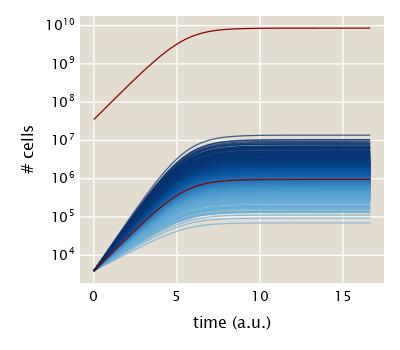

In [9]:
# Define number of points
n_points = 200

# Define time range
t = LinRange(t_span[1], t_span[2], n_points)

# Evaluate interpolator
n = hcat(map(sol, t)...)

# Initialize figure
fig = Figure(resolution=(400, 350))

# Get colors for plot
colors = get(ColorSchemes.Blues_9, LinRange(0.5, 1, n_mut + 1))
# Add axis
ax = Axis(fig[1, 1], xlabel="time (a.u.)", ylabel="# cells", yscale=log10)

# Loop through mutants
for (i, mut) in enumerate(eachrow(n[2:end-1, :]))
    # Plot trajectory
    lines!(ax, t, mut, color=(colors[i], 0.75))
end # for

# Add reference strain and neutral lineage
lines!(ax, t, n[1, :], color=:darkred)
lines!(ax, t, n[end, :], color=:darkred)

fig

The integration is growing as expected, so we can proceed with the computation
that concerns us: a serial dilution experiment over several cycles.

We will integrate the system, take the final point as the next initial condition
and iterate.

In [10]:
# Define number of cycles to run
n_cycles = 5

# Inititalize matrix to save output
n_mat = Matrix{Float64}(undef, n_cycles + 1, n_mut + 1)

# Store initial condition
n_mat[1, :] .= n₀

# Loop through cycles
for cyc = 2:n_cycles+1
    # Define ODE problem
    local prob = ODEProblem(
        # dndt_rhs!, n_mat[cyc-1, :] ./ 2^(n_gen), t_span, (λ, κ)
        dndt_rhs!, n_mat[cyc-1, :], t_span, (λ, κ)
    )
    # Solve system and store final point
    n_mat[cyc, :] = solve(prob).u[end] ./ 2^(n_gen)
end # for

Let's now look at the number of cells at the end of each cycle.

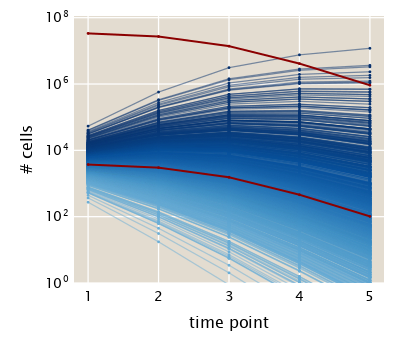

In [11]:
# Initialize figure
fig = Figure(resolution=(400, 350))

# Add axis
ax = Axis(fig[1, 1], xlabel="time point", ylabel="# cells", yscale=log10)

# Loop through mutants
for (i, mut) in enumerate(eachcol(n_mat[2:end, 2:end-1]))
    # Plot trajectory
    lines!(ax, mut, color=(colors[i], 0.5))
    scatter!(ax, mut, markersize=4, color=colors[i])
end # for

# Add ancestral strain
scatterlines!(ax, n_mat[2:end, 1], color=:darkred, linewidth=2, markersize=4)

# Add neutral lineage
scatterlines!(ax, n_mat[2:end, end], color=:darkred, linewidth=2, markersize=4)

ylims!(ax, low=1)

fig

Now, let's convert this simulation into the type of data we would obtain in a
fitness measurement experiment. This means that we remove the counts from the
ancestral strain and compute the relative frequencies for each strain.

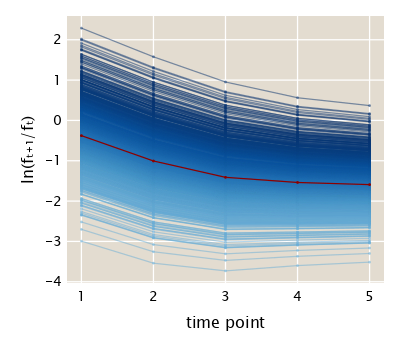

In [13]:
# Compute the frequencies for all non-ancestral strains
f_mat = n_mat[:, 2:end] ./ sum(n_mat[:, 2:end], dims=2)

# Compute the frequency ratios
γ_mat = f_mat[2:end, :] ./ f_mat[1:end-1, :]

# Initialize figure
fig = Figure(resolution=(400, 350))

# Add axis
ax = Axis(fig[1, 1], xlabel="time point", ylabel="ln(fₜ₊₁/fₜ)")

# Loop through mutants
for (i, mut) in enumerate(eachcol(γ_mat[:, 1:end-1]))
    # Plot mutant trajectory
    scatterlines!(ax, log.(mut), color=(colors[i], 0.5), markersize=4)
end # for

# Add neutral lineage trajectory
scatterlines!(ax, log.(γ_mat[:, end]), color=:darkred, markersize=4)

fig

The data looks qualitatively very similar to the experimental results we obtain.
To make the simulation more realistic, let's add Poisson noise during the
dilution step.

In [14]:
@doc raw"""
    logistic_fitness_measurement(n_cycles, t_cycle, λ_array, κ)

Function to simulate fitness measurment experiments over multiple
growth-dilution cycles using a logistic growth model of the form

ṅᵢ = λᵢnᵢ (1 - ∑ᵢ(nᵢ)/κ),

and a Poisson sampling at each dilution step.

# Arguments
- `λ̲::Vector{Float64}`: Vector of growth rate values for all genotypes. NOTE:
  The reference growth rate (usually the neutral lineage) should be the *first
  entry* of this vector.
- `n̲₀::Vector{Int64}`: Vector with the initial frequencies for all genotypes to
  track.

# Optional Keyword Arguments
- `n_cycles::Int64=4`: Number of growth-dilution cycles over which to integrate
  the dynamics.
- `n_gen::Int64=8`: Number of generations that the reference strain goes through
  for every growth cycle.
- `exp_frac::Float64=1/3`: Fraction of the growth-dilution cycle that cells
  spend on exponential growth. NOTE: The total time of integration is computed
  as
  - `log(2) / first(λ̲) * n_gen / exp_frac`
- `κ::Float64=10.0^10`: Environment carrying capacity.
- `dilution::Union{Nothing,Float64}=nothing`: Dilution factor after every growth
  cycle. The initial condition for the next cycle are computed as
  - `solve(prob).u[end] ./ dilution`.
  if `typeof(dilution) == Nothing` the dilution factor is `1 / 2^n_gen`.

# Returns
- `Matrix{Int64}`: `(n_cycles + 1) × n_genotypes` matrix with the barcode count
  trajectories for all genotypes.
"""
function logistic_fitness_measurement(
    λ̲::Vector{Float64},
    n̲₀::Vector{Int64};
    n_cycles::Int64=4,
    n_gen::Int64=8,
    exp_frac::Float64=1 / 3,
    κ::Float64=10.0^10,
    dilution::Union{Nothing,Float64}=nothing
)
    # Check the input exp_frac
    if !(0 < exp_frac < 1)
        error("exp_frac must be ∈ (0, 1]")
    end # if
    # Check the positivity of initial populations
    if any(n̲₀ .< 0)
        error("Initial populations cannot be negative")
    end # if
    # Check that the initial population is not larger than the carrying capacity
    if sum(n̲₀) ≥ κ
        error("The initial population is larger than the carrying capacity")
    end # if

    # Define time span
    t_span = (0.0, log(2) / first(λ̲) * (n_gen / exp_frac))

    # Define number of genotypes
    n_geno = length(λ̲)

    # Inititalize matrix to save output
    n_mat = Matrix{Int64}(undef, n_cycles + 1, n_geno)

    # Store initial condition
    n_mat[1, :] = n̲₀

    # Loop through cycles
    for cyc = 2:n_cycles+1
        # Define initial condition for next cycle with Poisson sampling.
        n_init = Random.rand.(
            Distributions.Poisson.(n_mat[cyc-1, :])
        )
        # Define ODE problem
        prob = ODEProblem(
            dndt_rhs!, n_init, t_span, (λ̲, κ)
        )
        # Check dilution factor
        if typeof(dilution) <: Nothing
            # Solve system and store final point
            n_mat[cyc, :] = Int64.(round.(solve(prob).u[end] ./ 2^(n_gen)))
        else
            # Solve system and store final point
            n_mat[cyc, :] = Int64.(round.(solve(prob).u[end] ./ dilution))
        end # if

    end # for

    return n_mat
end # function

logistic_fitness_measurement

Let's test the function.

In [25]:
Random.seed!(42)

# Define ancestral strain growth rate
λ_a = 1.0
# Define carrying capacity
κ = 10.0^10
# Define number of generations
n_gen = 8
# Define number of neutral and mutants
n_neutral, n_mut = [50, 450]
# Define number of barcodes
n_bc = n_neutral + n_mut

# Compute initial number of cells
n_init = κ / (2^(n_gen))

# Define fracton of culture that is ancestor
frac_anc = 0.99

# Define initial number of cells
n₀ = [
    # ancestor
    Int64(round(n_init * frac_anc))
    # neutrals
    rand(
        Distributions.Poisson(n_init * (1 - frac_anc) / n_bc),
        n_neutral
    )
    # mutants
    rand(
        Distributions.Poisson(n_init * (1 - frac_anc) / n_bc),
        n_mut
    )
]

# Initialize array to store growth rates
λ̲ = Vector{Float64}(undef, n_bc + 1)

# Set neutral growth rates
λ̲[1:n_neutral+1] .= λ_a

# Define standard deviation to sample growth rates
σ_λ = 0.005

# Sample mutant growth rates
λ̲[n_neutral+2:end] .= sort!(
    rand(
        Distributions.truncated(
            Distributions.Normal(λ_a * 1.005, σ_λ), λ_a * 0.99, λ_a * 1.05
        ), n_mut
    )
)

# Run simulation
n_mat = logistic_fitness_measurement(λ̲, n₀; n_gen=n_gen, κ=κ)

5×501 Matrix{Int64}:
 38671875  803  756  760  779  798  …   855   820   781   817   793   815
 38659209  800  801  764  802  747      942   884   828   883   858   918
 38648210  809  830  778  834  767     1092  1009   934   968   967  1013
 38636926  807  829  835  845  775     1177  1086  1016  1037  1112  1189
 38625236  838  767  855  806  754     1338  1165  1077  1160  1234  1301

Let's look at the resulting trajectories.

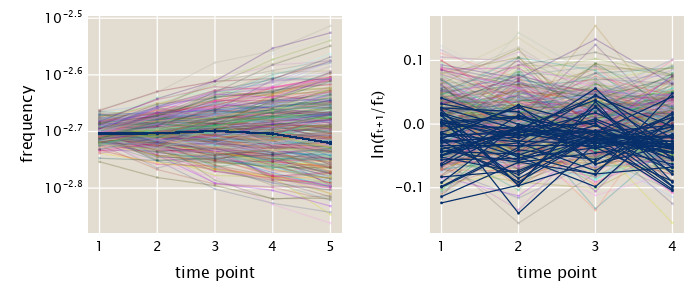

In [26]:
# Compute the frequencies for all non-ancestral strains
f_mat = (n_mat[:, 2:end] ./ sum(n_mat[:, 2:end], dims=2)) .+ 1E-9

# Compute the frequency ratios
γ_mat = f_mat[2:end, :] ./ f_mat[1:end-1, :]

# Initialize figure
fig = Figure(resolution=(350 * 2, 300))

# Add axis
ax1 = Axis(fig[1, 1], xlabel="time point", ylabel="frequency", yscale=log10)
ax2 = Axis(fig[1, 2], xlabel="time point", ylabel="ln(fₜ₊₁/fₜ)")

# Define colors
color = ColorSchemes.glasbey_hv_n256

# Loop through mutants
for mut in (n_neutral+1):(n_bc)
    # Sample color
    col = (color[StatsBase.sample(1:length(color))], 0.25)
    # Plot mutant frequency trajectory
    scatterlines!(ax1, f_mat[:, mut], color=col, markersize=4)
    # Plot mutant log-frequency ratio trajectory
    scatterlines!(ax2, log.(γ_mat[:, mut]), color=col, markersize=4)
end # for

# Loop through neutrals
for neutral in 1:n_neutral
    # Plot neutral frequency trajectory
    scatterlines!(
        ax1,
        f_mat[:, n_neutral],
        color=ColorSchemes.Blues_9[end],
        markersize=4
    )

    # Plot mutant trajectory
    scatterlines!(
        ax2,
        log.(γ_mat[:, neutral]),
        color=ColorSchemes.Blues_9[end],
        markersize=4
    )
end # for

fig